# Clipping an image

In this tutorial, we are going to focus on how to clip a satellite image, and then export the resulting data. 

This is an essential skill, as you need to be able to read in, manipulate and export imagery for a specific Area of Interest (AoI).

In previous classes, you have critically reviewed the imagery available from major providers. Therefore, you should see the value in being able to take these large image assets, and clip them down to a desired AoI.



## Planet sign-up

Can you please first sign up for an educational account from Planet. 

This enables you to access Planet imagery via either PlanetExplorer or the available API.

See here:

- https://www.planet.com/markets/education-and-research/#apply-now
- https://pypi.org/project/planet/
- https://github.com/planetlabs/planet-client-python
        

Next, let us begin by importing a desired image, such as the one provided for this exercise in the `files` folder:

- "20220820_154153_46_248f_3B_AnalyticMS.tif"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


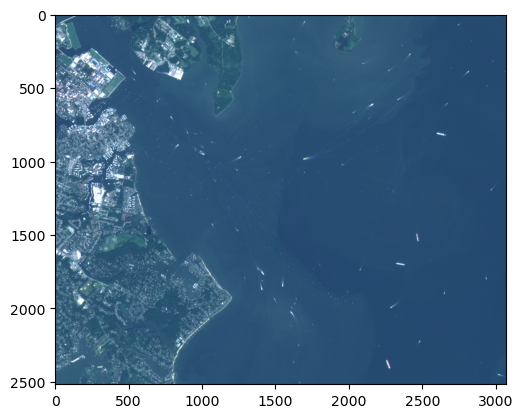

In [2]:
#Example

#import our desired packages
import rasterio #rasterio helps us read the raster image file
from matplotlib import pyplot as plt #pyplot helps us plot/visualize our image data
import numpy as np #numpy helps us scale our underlying band values

#specify desired filename
image_file = "files/20220820_154153_46_248f_3B_AnalyticMS.tif"

#define a rasterio object so we can use rasterio functions
my_raster_image = rasterio.open(image_file)

#scale values for display purposes
def scale(band): 
    return band / 10000.0

#import our multiband layers - blue, green red
blue = scale(my_raster_image.read(1))
green = scale(my_raster_image.read(2))
red = scale(my_raster_image.read(3))

#stack them into a single image for a true color composite
my_image = np.dstack((red, green, blue))

#show our image using pylot
plt.imshow(my_image)

# Export the layer to a .png image.
plt.savefig('export_annapolis.png', bbox_inches='tight')

You should be able to see an image of Annapolis harbour, Maryland, on the Chesapeake Bay. We are going to try cut out a smaller part of this image.   

However, we will need to have an Area of Interest (AoI) shape to intersect with the existing image. 

We can get this shape in multiple ways:
- Specify our own geojson file (as we will do here), or, 
- Import an existing .shp file using either `geopandas` or `fiona` (geospatial Python packages).

First, we are going to try create our own geojson file, as it is easier for this initial example today. 

Let us get the bounding box coordinates for our current image. Remember these represent the minimum and maximum values on the x and y axes. 

In [5]:
# Example

#get bounds
xmin, ymin, xmax, ymax = my_raster_image.bounds
print(xmin, ymin, xmax, ymax)

370695.0 4309491.0 379908.0 4317045.0


We can now create a geojson using these coordinates. 

Remember we have covered geojson data structures before, earlier in this class. It is well-documented here: https://geojson.org/

The trick is to make sure you get the structure correct for the shape type you are using (so you can not have too many or too few brackets, which is a common mistake made, especially when switching between points and polygons). 

In this example, if we use the same coordinates as the existing bounding box, we will just produce the same image. Therefore, we need to change the coordinates to an area inside our existing box ready for clipping. 

We can do this by obtaining the range of the values on the x and y axes. And then respecifying the min and max values, making this image only a certain proportion of the original image area. 

If you prefer to do this manually, you can. Let us first cover how to do this using some code.  

In [6]:
# Example

#get bounds
xmin, ymin, xmax, ymax = my_raster_image.bounds

# Let us get the x and y range first 
x_range = xmax - xmin
y_range = ymax - ymin
print(round(x_range), round(y_range))

print("Initial values are {}, {}, {} and {}".format(
    round(xmin), 
    round(ymin), 
    round(xmax), 
    round(ymax))
)

# Then we can respecify the maximum values to be smaller
# This way we can get an AoI inside this existing image
xmin = xmin + (x_range / 3)
ymin = ymin + (y_range / 3)
xmax = xmax - (x_range / 3)
ymax = ymax - (y_range / 3)

# Here we can check these
print("Final values are {}, {}, {} and {}".format(
    round(xmin), 
    round(ymin), 
    round(xmax), 
    round(ymax))
)

9213 7554
Initial values are 370695, 4309491, 379908 and 4317045
Final values are 373766, 4312009, 376837 and 4314527


Now we can specify our AoI geojson polygon:

You can see how the coordinates for each corner of the polygon are stated, to form our square AoI box. 

In [8]:
# Example

# let us define our geometry type, which as we have a square, is a polygon.

# if you are stuck on geojson polygon structure, go read the specification:
# here: https://www.rfc-editor.org/rfc/rfc7946
# or here: https://en.wikipedia.org/wiki/GeoJSON
    
my_geojson = [{
	"type": "Polygon", 
	"coordinates": [ 
	  [
		[xmin, ymin],
		[xmax, ymin],
		[xmax, ymax],
		[xmin, ymax],
		[xmin, ymin]
	  ],
	]
  }]
my_geojson

[{'type': 'Polygon',
  'coordinates': [[[373766.0, 4312009.0],
    [376837.0, 4312009.0],
    [376837.0, 4314527.0],
    [373766.0, 4314527.0],
    [373766.0, 4312009.0]]]}]

Now we have our geojson, we can use it to clip the existing satellite image we have. 

We need to utilize a function from `rasterio` called `mask`. 

*Masking is a technique used to clarify dense or detailed map content by having the features of one layer hide, or mask, features of another layer where they overlap.*

In [9]:
# Example
from rasterio.mask import mask

Now that we have the `mask` function loaded, we can implement this function as follows. 

Below you will see that `rasterio` essentially opens the file (see the `with rasterio.open()` statement), applies the mask (see the `mask(img, my_geojson, crop=True)` statement, and then returns the clipped data (e.g. `clipped, transform =`).

In [10]:
# Example

# Now we can apply the rasterio mask 
# We specify the function needs to crop (via crop=True)
with rasterio.open(image_file) as img:
    clipped, transform = mask(img, my_geojson, crop=True)
    
# You can view your clipped multiband numpy array
print(clipped)

[[[   0 4612 4633 ... 4450 4484    0]
  [   0 4646 4643 ... 4536 4548    0]
  [   0 4657 4627 ... 4573 4570    0]
  ...
  [   0 4888 4855 ... 4452 4475    0]
  [   0 4914 4855 ... 4430 4437    0]
  [   0 4886 4854 ... 4463 4463    0]]

 [[   0 3289 3307 ... 3066 3056    0]
  [   0 3290 3328 ... 3056 3033    0]
  [   0 3306 3352 ... 3041 3053    0]
  ...
  [   0 3630 3661 ... 3008 2975    0]
  [   0 3668 3703 ... 3011 3018    0]
  [   0 3686 3689 ... 3019 3021    0]]

 [[   0 1738 1726 ... 1699 1697    0]
  [   0 1719 1730 ... 1645 1649    0]
  [   0 1737 1745 ... 1615 1594    0]
  ...
  [   0 2089 2084 ... 1532 1499    0]
  [   0 2093 2077 ... 1574 1552    0]
  [   0 2061 2047 ... 1529 1535    0]]

 [[   0  853  750 ...  607  619    0]
  [   0  813  756 ...  598  570    0]
  [   0  819  783 ...  541  604    0]
  ...
  [   0  969 1014 ...  594  611    0]
  [   0  835  939 ...  547  601    0]
  [   0  825  839 ...  538  656    0]]]


Finally, before we can write this to a file, we need to copy over the metadata from the original image and apply it to our cropped version. This helps inform any (GIS) software used to load the image, about how to display the underlying data (e.g. projection). 

We can begin by copying the metadata from the original image, and then updating the height/width parameters. 

In [11]:
# Example

# Let us copy the metadata from the original ratserio object
meta = my_raster_image.meta.copy()

# We will need to update this metadata, and provide the new clipped boundaries
meta.update(
    {
    
        "transform": transform,
        "height":clipped.shape[1],
        "width":clipped.shape[2]
    }
)
print(meta)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 1025, 'height': 840, 'count': 4, 'crs': CRS.from_epsg(32618), 'transform': Affine(3.0, 0.0, 373764.0,
       0.0, -3.0, 4314528.0)}


And now finally we can write all this information.

We can use the `with rasterio.open()` command to open a new `.tif` file called `clipped.tif`.

Note: the `'w'` denotes we are intending to write to this file, as opposed to if we used `'r'` which would indicate we wanted to read a file. 

The `**meta` tag sees us allocate the edited metadata to the file we are writing called `clipped.tif`.


In [12]:
# Example

# Finally, we can write new image to a GeoTIFF
with rasterio.open('clipped.tif', 'w', **meta) as my_writer_object:
    my_writer_object.write(clipped)
    
print('Writing complete')

Writing complete


Now we should be able to view the image.

Go find the `clipped.tif` file and open it in your preferred GIS software. You can compare the extent of the clipped version to the original image. 


## Exercise

In the following task, you should first obtain an image of your choice from one of your chosen providers (Maxar, Planet etc.).

Carry out a sequence of processing steps as follows:

- Import the image using `rasterio`.
- Inspect that the image has been loaded correctly.
- Create another spatial object (e.g. a geojson bounding box) to use as the mask boundary.
- Use `rasterio` to clip the image and inspect the result.
- Write out the image to a chosen location.
- Critically review your image, what is present, and also reflect on your method. 

In [ ]:
#Enter your code here
